In [1]:
import hdf5tools
from matplotlib import pyplot as plt
import os
import glob
import h5py
import numpy as np

c:\users\user\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = hdf5tools.produce_labeled_h5s("Data", samplecosmics=True)

['Data\\fardet_genie_fluxswap_genierw_fhc_v08_1000_r00013906_s40_c000_N19-03-11_v1_20170915_165654_sim.h5caf.h5', 'Data\\fardet_genie_fluxswap_genierw_fhc_v08_1000_r00013909_s14_c000_N19-03-11_v1_20170915_165654_sim.h5caf.h5']
Processing Data\fardet_genie_fluxswap_genierw_fhc_v08_1000_r00013906_s40_c000_N19-03-11_v1_20170915_165654_sim.h5caf.h5 at 2019-11-09 20:24:59.018121
3161 cosmics out of 3407 total events and 27 will be retained
[   0    1    2 ... 3404 3405 3406]
Downsampling cosmics to 10%...
(273, 2, 80, 100, 1)
(273,)
name:  Data\fardet_genie_fluxswap_genierw_fhc_v08_1000_r00013906_s40_c000_N19-03-11_v1_20170915_165654_sim.h5caf.h5
name:  Data\labeled_downsampled\labeled_0_fardet_genie_fluxswap_genierw_fhc_v08_1000_r00013906_s40_c000_N19-03-11_v1_20170915_165654_sim.h5caf.h5
Data\labeled_downsampled\labeled_0_fardet_genie_fluxswap_genierw_fhc_v08_1000_r00013906_s40_c000_N19-03-11_v1_20170915_165654_sim.h5caf.h5 written at 2019-11-09 20:24:59.771749
Elapsed time: 0.75362801551

In [3]:
import os
import glob
import h5py
import numpy as np

filenames = glob.glob('Data/labeled_downsampled/*.h5')

print("filenames: ",filenames)


pm = np.empty((0, 2, 80, 100, 1), dtype=np.uint8)
lb = np.empty((0), dtype=np.uint8)

for fn in filenames:
    cf = h5py.File(fn)
    pm = np.concatenate((pm, cf.get('pixelmaps')), axis=0)
    lb = np.concatenate((lb, cf.get('labels')))

print(pm.shape)
print(lb.shape)

uq, hist = np.unique(lb, return_counts=True)

print(uq)
print(hist) 

filenames:  ['Data/labeled_downsampled\\labeled_0_fardet_genie_fluxswap_genierw_fhc_v08_1000_r00013906_s40_c000_N19-03-11_v1_20170915_165654_sim.h5caf.h5', 'Data/labeled_downsampled\\labeled_1_fardet_genie_fluxswap_genierw_fhc_v08_1000_r00013909_s14_c000_N19-03-11_v1_20170915_165654_sim.h5caf.h5']
(554, 2, 80, 100, 1)
(554,)
[0 1 3 4]
[  3 402  94  55]


1


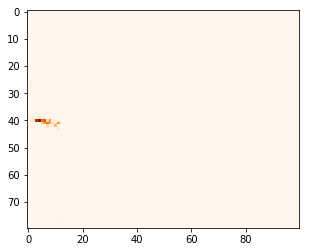

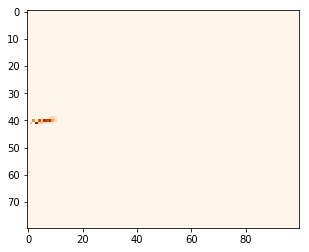

0

In [6]:
from sklearn.model_selection import train_test_split

pmaps_train, pmaps_test, y_train, y_test = train_test_split(pm, lb, test_size=1/4, random_state=42)

X1_train0 = pmaps_train[:,0]
X2_train0 = pmaps_train[:,1]

X1_test0 = pmaps_test[:,0]
X2_test0 = pmaps_test[:,1]

test_id = 23
print(y_train[test_id])
hdf5tools.print_pixelmaps(pmaps_train,test_id)

In [7]:
from keras.utils import np_utils

X1_train = X1_train0.astype('float32')/255
X2_train = X2_train0.astype('float32')/255
Y_train = np_utils.to_categorical(y_train,5)
           
X1_test = X1_test0.astype('float32')/255
X2_test = X2_test0.astype('float32')/255
Y_test = np_utils.to_categorical(y_test,5)

Using TensorFlow backend.
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [8]:
import models
import keras

In [40]:
model = models.CVNShortSimple()

In [41]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [42]:
from keras.callbacks import TensorBoard

tb = TensorBoard(histogram_freq=0,
                 write_graph=True,
                 write_grads=False,
                 write_images=True)


history = model.fit([X1_train,X2_train], Y_train, batch_size=16, epochs=10, verbose=1,
                    validation_data=([X1_test,X2_test], Y_test), callbacks=[tb])

Train on 415 samples, validate on 139 samples
Epoch 1/10
415/415 [==============================] - 94s 226ms/step - loss: 1.8263 - acc: 0.6916 - val_loss: 2.1570 - val_acc: 0.2158
Epoch 2/10
415/415 [==============================] - 67s 161ms/step - loss: 1.5071 - acc: 0.7373 - val_loss: 3.1931 - val_acc: 0.1079
Epoch 3/10
415/415 [==============================] - 69s 166ms/step - loss: 1.1560 - acc: 0.8096 - val_loss: 6.6020 - val_acc: 0.1079
Epoch 4/10
415/415 [==============================] - 76s 183ms/step - loss: 1.2726 - acc: 0.8120 - val_loss: 6.7432 - val_acc: 0.1079
Epoch 5/10
415/415 [==============================] - 67s 161ms/step - loss: 0.9799 - acc: 0.8747 - val_loss: 10.1503 - val_acc: 0.1079
Epoch 6/10
415/415 [==============================] - 66s 159ms/step - loss: 1.0264 - acc: 0.8530 - val_loss: 13.6503 - val_acc: 0.1079
Epoch 7/10
415/415 [==============================] - 68s 165ms/step - loss: 1.0807 - acc: 0.8723 - val_loss: 13.4323 - val_acc: 0.1079
Epoch 

In [55]:
h5py.File("Predictions/{nm}/test".format(nm="CVN"), 'w')

<HDF5 file "test" (mode r+)>

In [45]:
from sklearn.metrics import confusion_matrix
import numpy as np

confusion = confusion_matrix(np.argmax(Y_train,axis=1), np.argmax(y_probs,axis=1))
print(confusion)

[[  0   0   0   2]
 [  0   0   0 309]
 [  0   0   0  64]
 [  0   0   0  40]]


In [44]:
y_probs

array([[5.85451761e-19, 1.29713863e-14, 7.51711800e-12, 1.09822246e-07,
        9.99999881e-01],
       [4.22828725e-19, 1.00645658e-14, 5.68531116e-12, 6.53931238e-08,
        9.99999881e-01],
       [4.71115083e-19, 1.27832002e-14, 6.06566533e-12, 6.23059151e-08,
        9.99999881e-01],
       ...,
       [3.59332299e-19, 2.79776931e-14, 4.00123858e-12, 1.34516434e-08,
        1.00000000e+00],
       [4.19376641e-19, 9.85785838e-15, 5.74238530e-12, 7.05375101e-08,
        9.99999881e-01],
       [6.18084398e-19, 1.23785403e-14, 8.05177973e-12, 1.40105442e-07,
        9.99999881e-01]], dtype=float32)

## Old method

In [12]:
for file0 in glob.glob("*.h5"):
   
    file = h5py.File(file0)
    pmaps0 = get_maps(file)
    pmaps = np.concatenate((pmaps,pmaps0),axis = 0)

    labels0 = get_labels(file)
    labels = np.concatenate((labels,labels0),axis = 0)

    print(file0)

fardet_genie_fluxswap_genierw_fhc_v08_1000_r00013909_s14_c000_N19-03-11_v1_20170915_165654_sim.h5caf.h5


In [13]:
labels.shape, pmaps.shape

((17224,), (17224, 2, 80, 100, 1))

In [14]:
import pandas as pd
np.savetxt('scratch_lb.csv', lb , delimiter=',', fmt='%s')

1


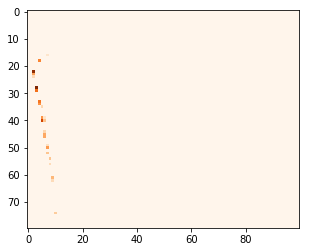

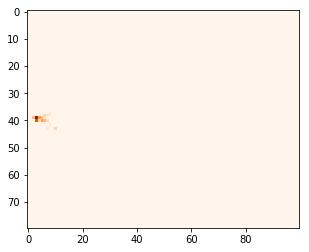

0

In [17]:
i=17
print(lb[i])
print_pixelmaps(pm,i,1)
print_pixelmaps(pm,i,0)